In [228]:
import pandas as pd
import numpy as np
from datetime import datetime
import utils
import importlib
import math 
import scipy.stats as stats

importlib.reload(utils)

<module 'utils' from '/Users/devyn/Computer Science/Data Science/da8_personal_project/utils.py'>

# Personal Strava EDA  

Write introduction and author here...

Write about `data` and attributes here...

## Collecting and Cleaning the Data  

Write the ways in which you are cleaning the data...  

In [229]:
utils.collectStravaData()
utils.collectWeatherData()

/Users/devyn/Computer Science/Data Science/da8_personal_project/utils.py:136: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned["Activity Date"] = pd.to_datetime(df_cleaned["Activity Date"])


For aggregation and hypothesis, maybe I can see if there is a correlatino between shorter workouts and higher heart rate 

## Merged Data  

Explain how you are merging the data here...

In [230]:
strava_df = pd.read_csv("devyn_CLEANED_strava_activities.csv")
weather_df = pd.read_csv("Spokane_CLEANED_daily_weather.csv")

merged_df = pd.merge(strava_df, weather_df, on="Activity Date", how="inner")
merged_df.to_csv("merged_data.csv")

## Strava Activity Stats  

Write here why you chose these statistics...

In [231]:
stats_ser = utils.calculateStravaStats()
print(stats_ser)

Total Activities                    158.00
Average Active Time (in minutes)     63.81
Average Temperature (F)              46.24
Average Heart Rate                  141.95
Average Relative Effort              70.09
Relative Effort StDev                49.98
Total Rowing Activities              96.00
Average RE for Rowing                83.80
Average Temp for Rowing (F)          49.33
Total Ride Activities                22.00
Average RE for Riding                60.41
dtype: float64


## Visualization  

Explain what visualization methods to use here...

Write here about the following graphs...

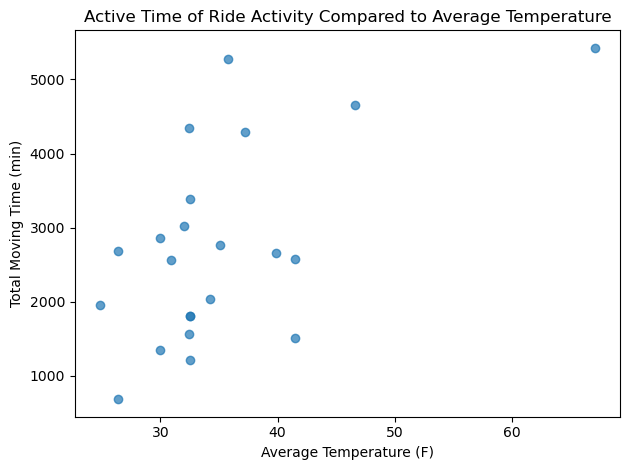

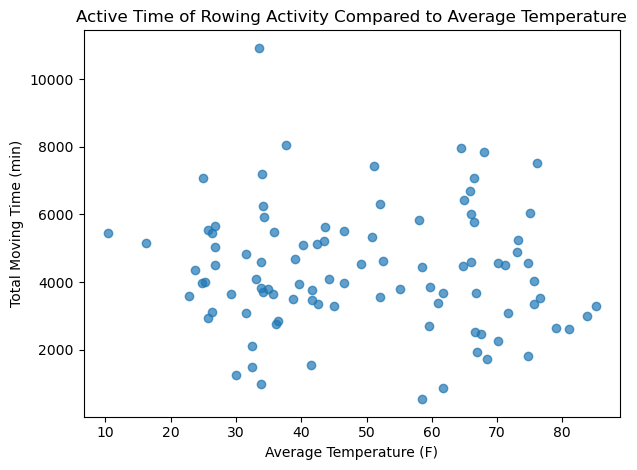

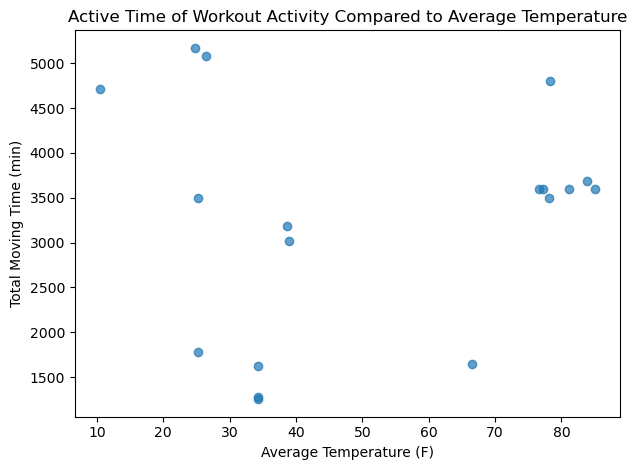

In [237]:
activity_df = merged_df.groupby("Activity Type")
activity_options = activity_df.groups.keys()

for activity in activity_options:
    group = activity_df.get_group(activity)
    utils.createTempScatter(activity, group)

Write here about the following graphs...

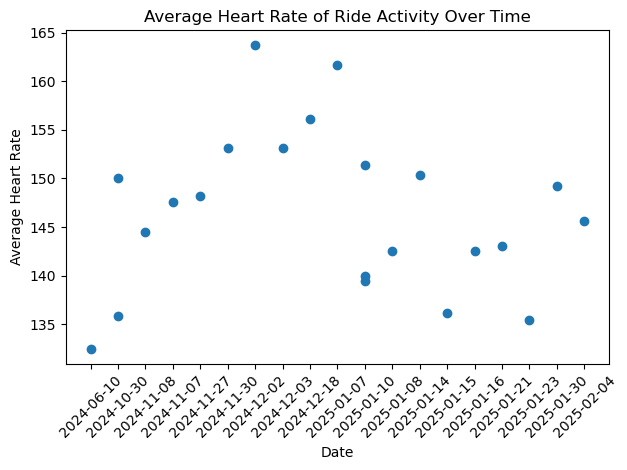

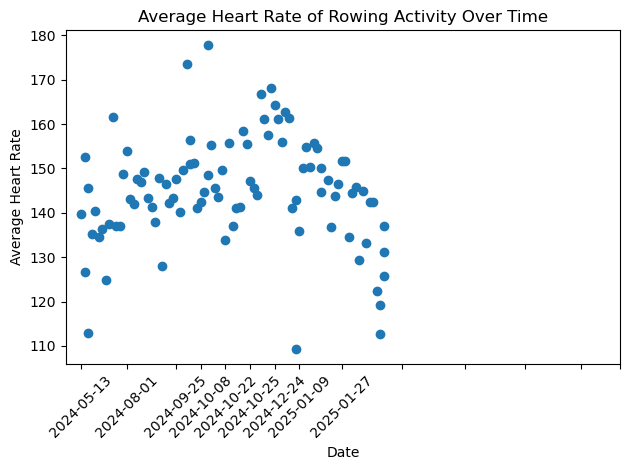

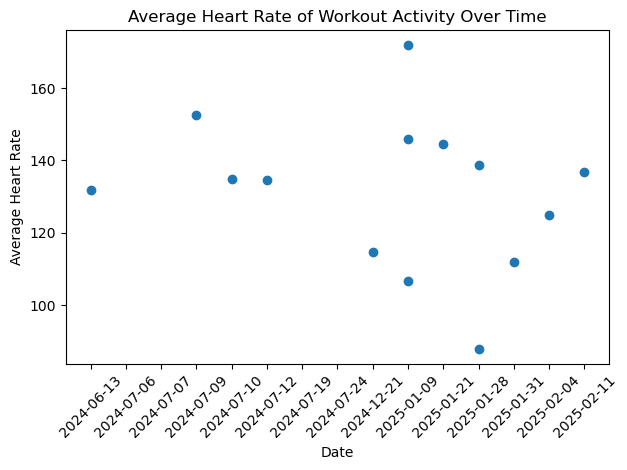

In [233]:
for activity in activity_options:
    group = activity_df.get_group(activity)
    utils.createHRHist(activity, group)

## Hypothesis Testing   

**The Question:** Is the mean average active minutes for Rowing Activities in December different from the mean average active minutes for Rowing Activities in January?  


**Step 1:**  
Identify the null hypothesis and alternative hypothesis.  

$H_{0}: \mu_{D} = \mu_{J}$   
$H_{1}: \mu_{D} \ne \mu_{J}$  

**Step 2:**  
Select the level of significance.  

$\alpha = 0.05$  

**Step 3:**  
Select the appropiate test statistic.  

$t=\frac{\overline{X_{1}}-\overline{X_{2}}}{\sqrt{s_{p}^{2}(\frac{1}{n_{1}}+\frac{1}{n_{2}})}}$   

**Step 4:** 
Formulate the decision rule.  

$df = n_{1} + n_{2} - 2$  
*df = 58, t-critical = 1.671*  

*If t-critical > 1.671 or t-critical < -1.671, then reject $H_{0}$*  

**Step 5:**  
Make a decision. 

In [235]:
rowing_df = activity_df.get_group("Rowing").copy()
rowing_df["Activity Date"] = pd.to_datetime(rowing_df["Activity Date"])

startDec = datetime.strptime("2024-12-1", "%Y-%m-%d")
endDec = datetime.strptime("2024-12-31", "%Y-%m-%d")
december_df = rowing_df[(rowing_df["Activity Date"] >= startDec) & (rowing_df["Activity Date"] <= endDec)]

startJan = datetime.strptime("2025-1-1", "%Y-%m-%d")
endJan = datetime.strptime("2025-1-31", "%Y-%m-%d")
january_df = rowing_df[(rowing_df["Activity Date"] >= startJan) & (rowing_df["Activity Date"] <= endJan)]

t_computed_6, p_val_6 = stats.ttest_ind(december_df["Moving Time"], january_df["Moving Time"], equal_var=False)
print("t_computed: ", t_computed_6, "\np_val: ", p_val_6)
alpha_6 = 0.05
if p_val_6 < alpha_6: 
    print("Reject H0") 
else: 
    print("Do not reject H0")

t_computed:  -2.88066862316203 
p_val:  0.008454751140829893
Reject H0


**Since t-critical < -1.671, then do reject $H_{0}$**   
**With a 0.05 significance level, it seems that the average active minutes of Rowing Activity in December was difference from the average active minutes in January.**